# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')

In [3]:
fp = (
    'https://raw.githubusercontent.com/alexeygrigorev/'
    'datasets/master/AER_credit_card_data.csv'
)

df = pd.read_csv(fp)

In [8]:
df.sample(n=8)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
242,yes,0,53.50000,1.500,0.000800,0.00000,yes,no,0,57,0,6
130,no,5,31.08333,4.200,0.000286,0.00000,no,no,3,52,0,19
613,yes,0,21.25000,1.990,0.034963,57.98083,no,no,2,8,1,5
338,yes,0,45.00000,4.030,0.040915,137.07170,no,no,0,72,1,2
963,yes,0,38.41667,5.600,0.093484,436.25920,yes,no,4,114,0,7
857,yes,0,26.08333,2.375,0.142851,282.72580,no,yes,1,114,1,1
497,no,2,27.50000,1.850,0.000649,0.00000,no,no,0,24,1,12
858,yes,0,30.16667,2.800,0.164386,383.56670,no,no,0,12,1,6


In [17]:
df.shape

(1319, 12)

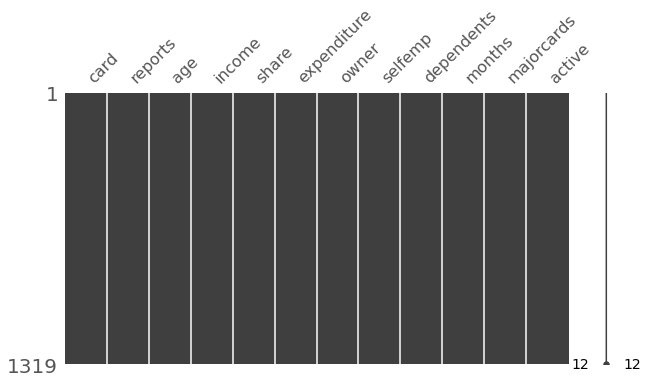

In [11]:
msno.matrix(df, figsize=(10, 5));

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
reports,1319.0,0.456406,1.345267,0.000000,0.000000,0.000000,0.000000,14.00000
age,1319.0,33.213103,10.142783,0.166667,25.416670,31.250000,39.416670,83.50000
income,1319.0,3.365376,1.693902,0.210000,2.243750,2.900000,4.000000,13.50000
share,1319.0,0.068732,0.094656,0.000109,0.002316,0.038827,0.093617,0.90632
expenditure,1319.0,185.057071,272.218917,0.000000,4.583333,101.298300,249.035800,3099.50500
dependents,1319.0,0.993935,1.247745,0.000000,0.000000,1.000000,2.000000,6.00000
months,1319.0,55.267627,66.271746,0.000000,12.000000,30.000000,72.000000,540.00000
majorcards,1319.0,0.817286,0.386579,0.000000,1.000000,1.000000,1.000000,1.00000
active,1319.0,6.996967,6.305812,0.000000,2.000000,6.000000,11.000000,46.00000


In [13]:
data, target = df.drop(columns=['card']), df['card'].map({'no':0, 'yes':1})

In [14]:
from sklearn.compose import make_column_selector as selector

numerical = selector(dtype_include=np.number)(data)
categorical = selector(dtype_include=object)(data)

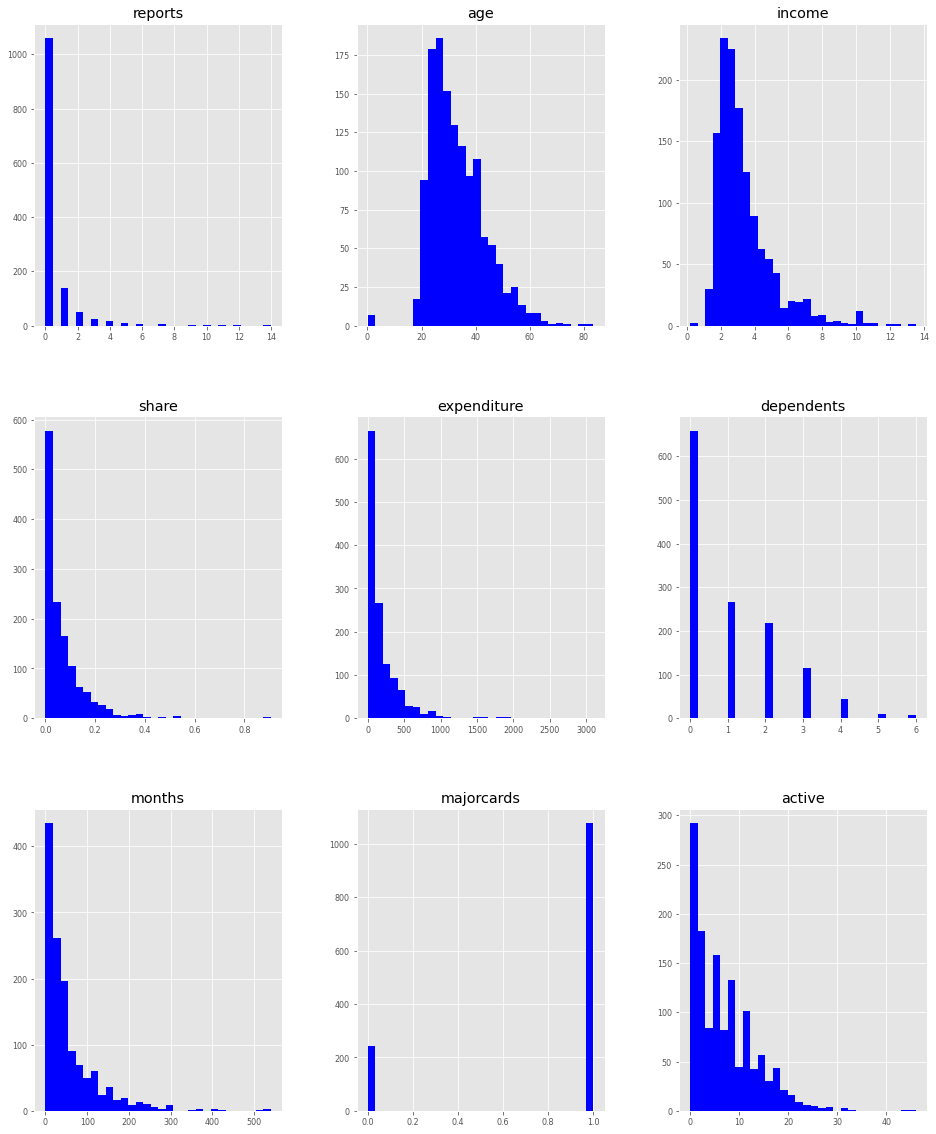

In [16]:
data[numerical].hist(figsize=(16, 20), color = 'b', bins=30, xlabelsize=8, ylabelsize=8);

# Split data

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    test_size=.2,
    stratify=target,
    random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1055, 11), (1055,), (264, 11), (264,))

# Models

In [23]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier
)
import xgboost


scaler = StandardScaler()
encoder_lreg = OneHotEncoder(handle_unknown='ignore')
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer([
    ('scaler_lreg', scaler, numerical),
    ('encoder_lreg', encoder_lreg, categorical)
])

models = [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    xgboost.XGBClassifier
]

for model in models:
  if model == LogisticRegression:
    cls = make_pipeline(preprocessor, model())
  else:
    cls = make_pipeline(encoder, model())
  
  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  cv_results = cross_validate(
      cls,
      data,
      target,
      cv=cv,
      scoring='roc_auc',
      return_train_score=True,
      error_score='raise',
      n_jobs = -1
  )

  print(f"{model.__name__:22} AUC: "
        f"{cv_results['test_score'].mean():.3f} STD: {cv_results['test_score'].std():.2f}"
  )


DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.986 STD: 0.01
DecisionTreeClassifier AUC: 0.560 STD: 0.05
HistGradientBoostingClassifier AUC: 0.754 STD: 0.05
RandomForestClassifier AUC: 0.730 STD: 0.06
XGBClassifier          AUC: 0.750 STD: 0.07
